In [5]:
import os

import tensorflow as tf

import tensorflow_hub as hub

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# For drawing onto the image.
import numpy as np
from PIL import Image
from PIL import ImageColor
from PIL import ImageDraw
from PIL import ImageFont


# For measuring the inference time.
import time

# Print Tensorflow version
print(tf.__version__)

# Check available GPU devices.
print("The following GPU devices are available: %s" % tf.test.gpu_device_name())

2.16.1
The following GPU devices are available: 


In [6]:
def display_image(image_path):
  image = mpimg.imread(image_path)
  fig = plt.figure(figsize=(20, 15))
  plt.grid(False)
  plt.imshow(image)

def display_np_image(image):
  fig = plt.figure(figsize=(20, 15))
  plt.grid(False)
  plt.imshow(image)

def draw_bounding_box_on_image(image,
                               ymin,
                               xmin,
                               ymax,
                               xmax,
                               color,
                               font,
                               thickness=4,
                               display_str_list=()):
  """Adds a bounding box to an image."""
  draw = ImageDraw.Draw(image)
  im_width, im_height = image.size
  (left, right, top, bottom) = (xmin * im_width, xmax * im_width,
                                ymin * im_height, ymax * im_height)
  draw.line([(left, top), (left, bottom), (right, bottom), (right, top),
             (left, top)],
            width=thickness,
            fill=color)

  # If the total height of the display strings added to the top of the bounding
  # box exceeds the top of the image, stack the strings below the bounding box
  # instead of above.
  display_str_heights = [font.getbbox(ds)[3] for ds in display_str_list]
  # Each display_str has a top and bottom margin of 0.05x.
  total_display_str_height = (1 + 2 * 0.05) * sum(display_str_heights)

  if top > total_display_str_height:
    text_bottom = top
  else:
    text_bottom = top + total_display_str_height
  # Reverse list and print from bottom to top.
  for display_str in display_str_list[::-1]:
    bbox = font.getbbox(display_str)
    text_width, text_height = bbox[2], bbox[3]
    margin = np.ceil(0.05 * text_height)
    draw.rectangle([(left, text_bottom - text_height - 2 * margin),
                    (left + text_width, text_bottom)],
                   fill=color)
    draw.text((left + margin, text_bottom - text_height - margin),
              display_str,
              fill="black",
              font=font)
    text_bottom -= text_height - 2 * margin


def draw_boxes(image, boxes, class_names, scores, max_boxes=10, min_score=0.1):
  """Overlay labeled boxes on an image with formatted scores and label names."""
  colors = list(ImageColor.colormap.values())

  try:
    font = ImageFont.truetype("/usr/share/fonts/truetype/liberation/LiberationSansNarrow-Regular.ttf",
                              25)
  except IOError:
    print("Font not found, using default font.")
    font = ImageFont.load_default()

  for i in range(min(boxes.shape[0], max_boxes)):
    if scores[i] >= min_score:
      ymin, xmin, ymax, xmax = tuple(boxes[i])
      display_str = "{}: {}%".format(class_names[i].decode("ascii"),
                                     int(100 * scores[i]))
      color = colors[hash(class_names[i]) % len(colors)]
      image_pil = Image.fromarray(np.uint8(image)).convert("RGB")
      draw_bounding_box_on_image(
          image_pil,
          ymin,
          xmin,
          ymax,
          xmax,
          color,
          font,
          display_str_list=[display_str])
      np.copyto(image, np.array(image_pil))
  return image

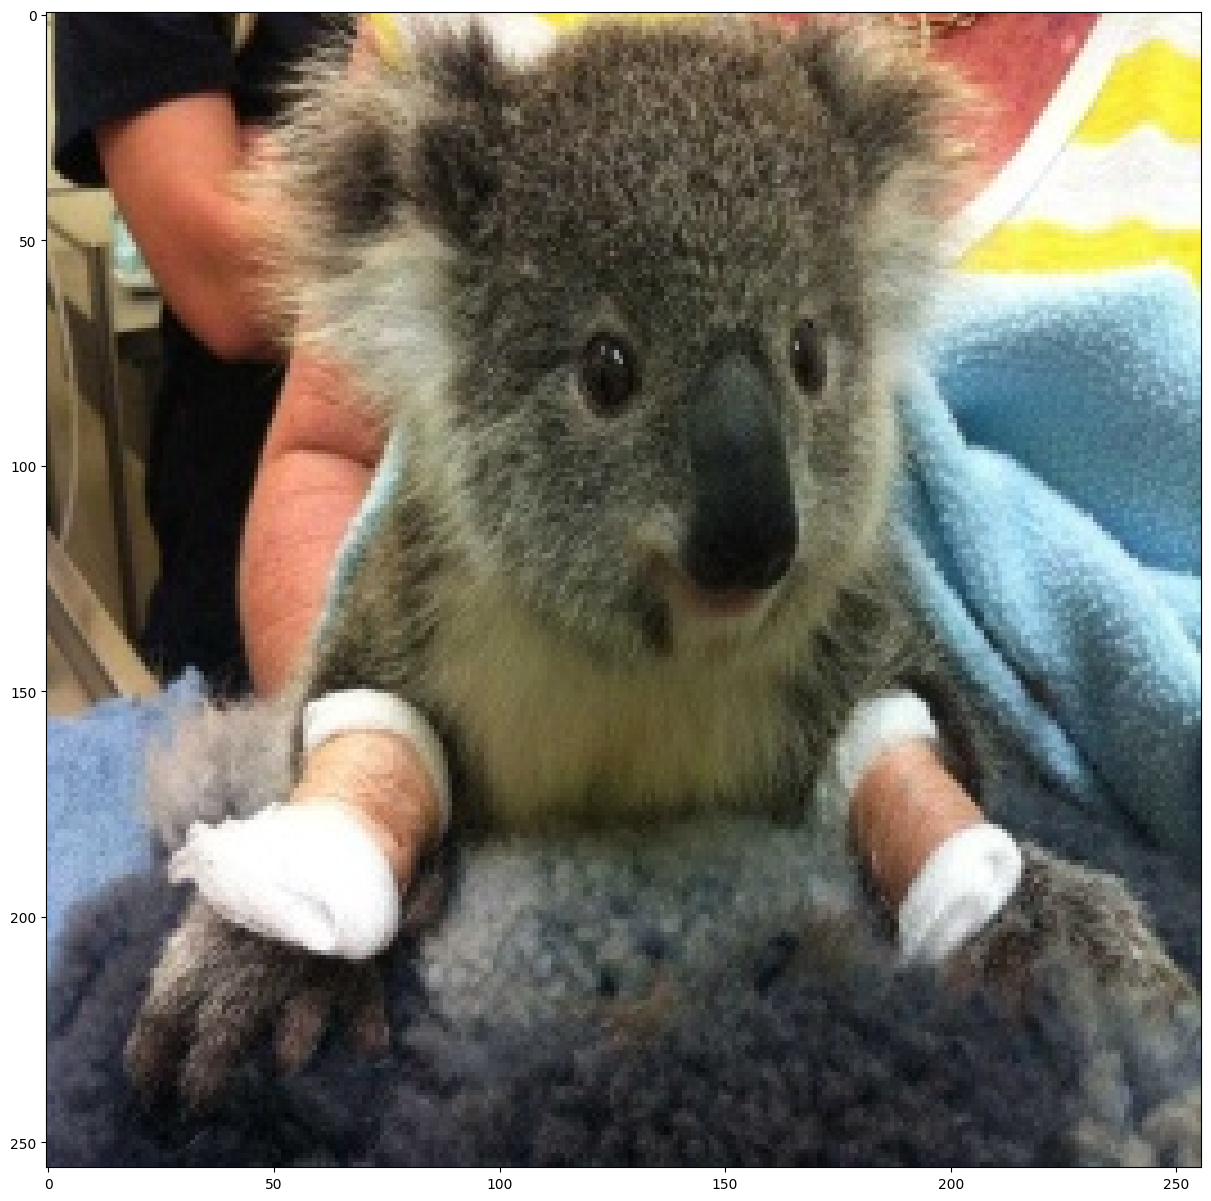

In [7]:
image_path = "static/test1.jpg"
display_image(image_path)

In [8]:
module_handle = "https://tfhub.dev/google/faster_rcnn/openimages_v4/inception_resnet_v2/1"
model_path = "local_resnet_model"

# Check if the model is already saved locally
if os.path.exists(model_path):
    # Load the model from the local path
    detector = tf.saved_model.load(model_path).signatures['default']
else:
    # Load the model from the URL
    detector = hub.load(module_handle).signatures['default']
    # Save the model locally
    tf.saved_model.save(detector, model_path)

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Assets written to: local_resnet_model/assets


INFO:tensorflow:Assets written to: local_resnet_model/assets


In [9]:
def load_img(path):
  img = tf.io.read_file(path)
  img = tf.image.decode_jpeg(img, channels=3)
  return img

In [10]:
def run_detector(detector, path):
    img = load_img(path)

    converted_img  = tf.image.convert_image_dtype(img, tf.float32)[tf.newaxis, ...]
    start_time = time.time()
    result = detector(converted_img)
    end_time = time.time()

    result = {key:value.numpy() for key,value in result.items()}

    # Filter detections for 'Koala'
    koala_indices = [i for i, class_entity in enumerate(result["detection_class_entities"]) if class_entity == b'Koala']
    koala_boxes = result["detection_boxes"][koala_indices]
    koala_class_entities = result["detection_class_entities"][koala_indices]
    koala_scores = result["detection_scores"][koala_indices]

    print("Found %d objects." % len(koala_scores))
    print("Inference time: ", end_time-start_time)

    image_with_boxes = draw_boxes(
        img.numpy(), koala_boxes,
        koala_class_entities, koala_scores)

    display_np_image(image_with_boxes)
    return result

W0000 00:00:1714917798.009803 8040088 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "CropAndResize" attr { key: "T" value { type: DT_FLOAT } } attr { key: "extrapolation_value" value { f: 0 } } attr { key: "method" value { s: "bilinear" } } inputs { dtype: DT_FLOAT shape { dim { size: -2484 } dim { size: -2485 } dim { size: -2486 } dim { size: 1088 } } } inputs { dtype: DT_FLOAT shape { dim { size: -105 } dim { size: 4 } } } inputs { dtype: DT_INT32 shape { dim { size: -105 } } } inputs { dtype: DT_INT32 shape { dim { size: 2 } } value { dtype: DT_INT32 tensor_shape { dim { size: 2 } } int_val: 17 } } device { type: "CPU" vendor: "GenuineIntel" model: "110" frequency: 1400 num_cores: 8 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 32768 l2_cache_size: 262144 l3_cache_size: 6291456 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { dim { size: -10

Found 3 objects.
Inference time:  60.274508237838745
Font not found, using default font.


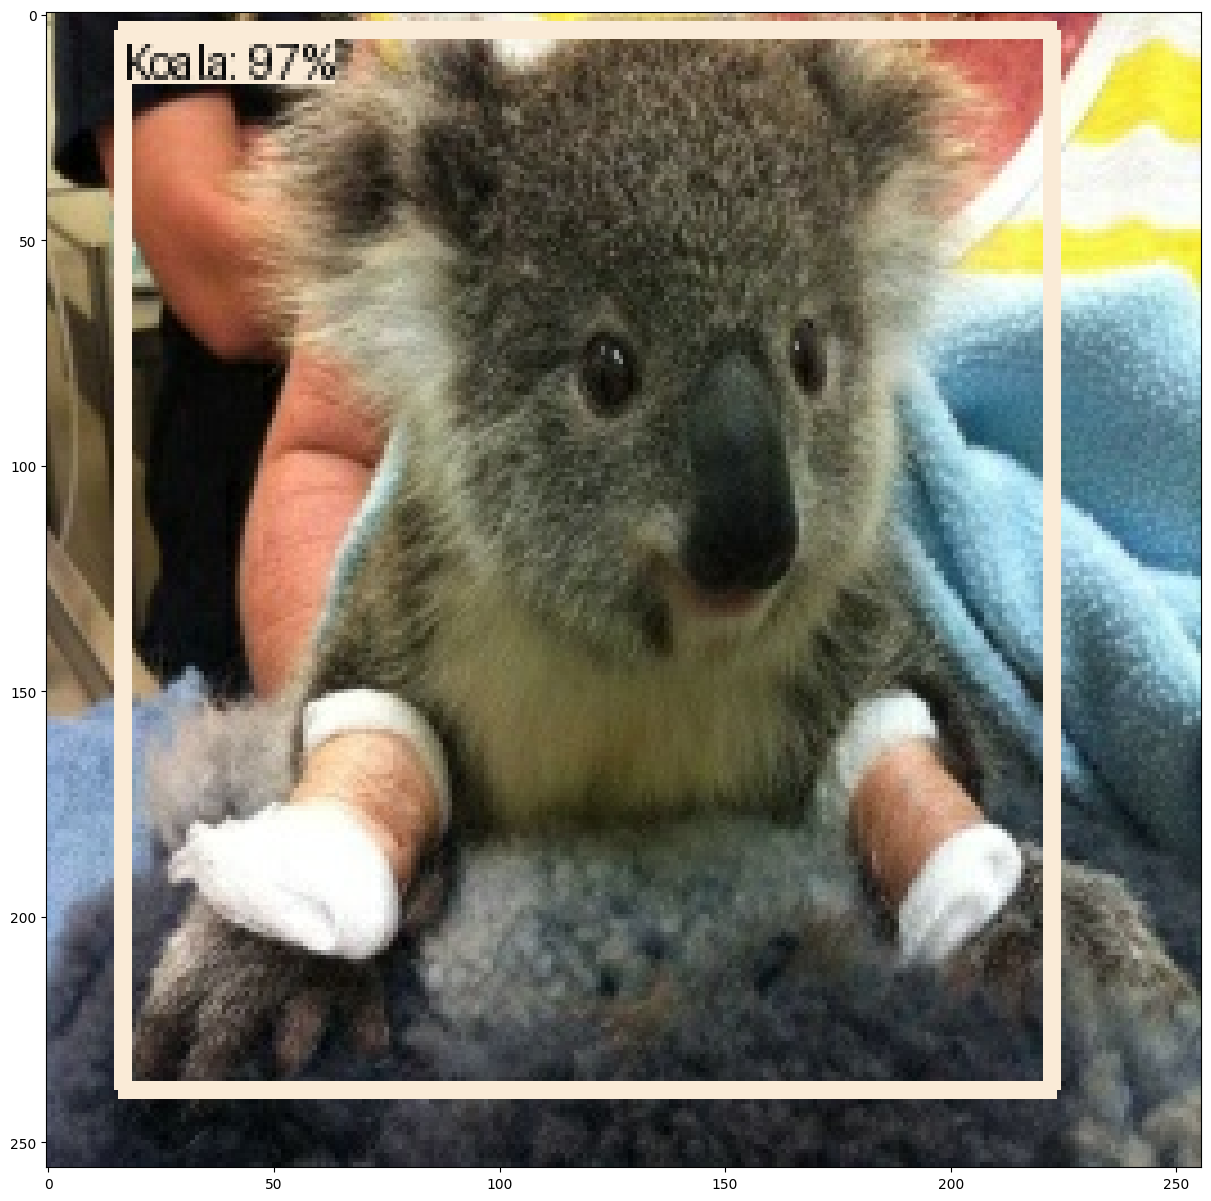

In [11]:
labels = run_detector(detector, image_path)

In [12]:
print(labels['detection_class_entities'])

[b'Koala' b'Clothing' b'Teddy bear' b'Person' b'Clothing' b'Man'
 b'Human arm' b'Koala' b'Toy' b'Clothing' b'Clothing' b'Clothing'
 b'Clothing' b'Clothing' b'Person' b'Fashion accessory' b'Animal'
 b'Person' b'Human arm' b'Clothing' b'Mammal' b'Clothing' b'Human arm'
 b'Human leg' b'Dog' b'Clothing' b'Human body' b'Cat' b'Panda' b'Man'
 b'Shorts' b'Brown bear' b'Clothing' b'Human arm' b'Mammal' b'Human leg'
 b'Fashion accessory' b'Bear' b'Woman' b'Carnivore' b'Human leg'
 b'Raccoon' b'Person' b'Jeans' b'Human hand' b'Man' b'Clothing'
 b'Human arm' b'Clothing' b'Monkey' b'Human arm' b'Human leg' b'Human leg'
 b'Clothing' b'Human hand' b'Red panda' b'Human arm' b'Human hand' b'Dog'
 b'Man' b'Polar bear' b'Human leg' b'Person' b'Cat furniture' b'Mammal'
 b'Mouse' b'Human leg' b'Plant' b'Mammal' b'Human ear' b'Jeans'
 b'Human arm' b'Human body' b'Human leg' b'Human arm' b'Clothing' b'Toy'
 b'Human arm' b'Mammal' b'Rabbit' b'Clothing' b'Human leg' b'Person'
 b'Koala' b'Human leg' b'Human ar